In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb


from plotnine import *

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [ ]:
# data: https://www.kaggle.com/competitions/2211-credit-card-churn-immune-online/data
df = pd.read_csv('/content/train.csv')

In [ ]:
df.head(20)

**Valores perdidos**

In [ ]:
df.isnull().sum()

customer_id                              0
customer_age                           429
education_level                        657
marital_status                         318
income_category                        501
number_products_customer                 0
weeks_tenure                             0
contacts_last_12mths                     0
credit_limit                             0
card_class                               0
inactive_months_last_12mths              0
total_revolving_balance                  0
count_transactions                       0
transactions_amount                      0
change_transaction_amt_last_3mths        0
change_transaction_count_last_3mths      0
churn                                    0
dtype: int64

In [ ]:
df.dtypes

customer_id                              int64
customer_age                           float64
number_products_customer                 int64
weeks_tenure                             int64
contacts_last_12mths                     int64
credit_limit                           float64
inactive_months_last_12mths              int64
total_revolving_balance                  int64
count_transactions                       int64
transactions_amount                      int64
change_transaction_amt_last_3mths      float64
change_transaction_count_last_3mths    float64
churn                                    int64
education_level_college                  uint8
education_level_graduate                 uint8
education_level_high school              uint8
education_level_phd                      uint8
education_level_post-graduate            uint8
education_level_uneducated               uint8
education_level_nan                      uint8
marital_status_divorced                  uint8
marital_statu

In [ ]:
df['customer_age'] = df['customer_age'].fillna(0)

In [ ]:
df = pd.get_dummies(df, columns = ['education_level', 'marital_status', 'income_category', 'card_class'], dummy_na = True)

In [ ]:
df.head()

,customer_id,customer_age,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,...,income_category_30k€-50k€,income_category_50k€-70k€,income_category_70k€-110k€,income_category_<30k€,income_category_nan,card_class_premium,card_class_red,card_class_red plus,card_class_red unlimited,card_class_nan
0,4278,0.0,4,216,1,16541.0,2,1428,82,4352,...,1,0,0,0,0,0,0,1,0,0
1,7300,45.0,5,115,3,1438.3,3,576,66,5098,...,0,0,0,1,0,0,1,0,0,0
2,6857,0.0,6,172,2,2293.0,1,1460,74,4436,...,1,0,0,0,0,0,1,0,0,0
3,2508,39.0,5,124,2,17523.0,2,0,54,1974,...,0,0,1,0,0,0,1,0,0,0
4,7859,40.0,2,107,2,4391.0,2,1933,36,1849,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
df['churn'].value_counts()

0    3248
1    1144
Name: churn, dtype: int64

In [ ]:
predictors = df.columns[df.columns != 'churn']
X = df[predictors]
X.drop(['customer_id'], axis = 1, inplace = True)
y = df['churn']

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
X.columns

Index(['customer_age', 'number_products_customer', 'weeks_tenure',
       'contacts_last_12mths', 'credit_limit', 'inactive_months_last_12mths',
       'total_revolving_balance', 'count_transactions', 'transactions_amount',
       'change_transaction_amt_last_3mths',
       'change_transaction_count_last_3mths', 'education_level_college',
       'education_level_graduate', 'education_level_high school',
       'education_level_phd', 'education_level_post-graduate',
       'education_level_uneducated', 'education_level_nan',
       'marital_status_divorced', 'marital_status_married',
       'marital_status_single', 'marital_status_nan', 'income_category_+110k€',
       'income_category_30k€-50k€', 'income_category_50k€-70k€',
       'income_category_70k€-110k€', 'income_category_<30k€',
       'income_category_nan', 'card_class_premium', 'card_class_red',
       'card_class_red plus', 'card_class_red unlimited', 'card_class_nan'],
      dtype='object')

In [ ]:
X.rename(columns={'income_category_<30k€': 'income_category_treinta', 
                   'income_category_70k€-110k€': 'income_category_setenta',
                   'income_category_30k€-50k€': 'income_category_cuarenta', 
                   'income_category_+110k€': 'income_category_cientodiez',
                   'income_category_50k€-70k€': 'income_category_sesenta',
                   'education_level_high school': 'education_level_high_school' }, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
X.head()

,customer_age,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,...,income_category_cuarenta,income_category_sesenta,income_category_setenta,income_category_treinta,income_category_nan,card_class_premium,card_class_red,card_class_red plus,card_class_red unlimited,card_class_nan
0,0.0,4,216,1,16541.0,2,1428,82,4352,0.846,...,1,0,0,0,0,0,0,1,0,0
1,45.0,5,115,3,1438.3,3,576,66,5098,0.774,...,0,0,0,1,0,0,1,0,0,0
2,0.0,6,172,2,2293.0,1,1460,74,4436,0.658,...,1,0,0,0,0,0,1,0,0,0
3,39.0,5,124,2,17523.0,2,0,54,1974,0.424,...,0,0,1,0,0,0,1,0,0,0
4,40.0,2,107,2,4391.0,2,1933,36,1849,0.579,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
sum(y) / len(y)

0.2604735883424408

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

xgb_model.score(X_test, y_test)

0.9522184300341296

In [ ]:
search_spaces = {'max_depth':Integer(2,6),
'min_child_weight':Integer(1,4),
'gamma': Real(0, 1),
'subsample': Real(0.6, 1),
 'colsample_bytree': Real(0, 1),
 'reg_alpha': Integer(0, 10),
 'learning_rate': Real(0.4, 1),
 'n_estimators': Integer(50,100)}


opt = BayesSearchCV(xgb_model, search_spaces, cv=10, verbose= 10)
opt.fit(X_train, y_train)


In [ ]:
print(opt.best_estimator_.get_params())
print(opt.best_score_)
print(opt.score(X_test, y_test))

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7981633976574217, 'gamma': 0.7377124113108194, 'learning_rate': 0.6281882010732335, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 86, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1.0, 'verbosity': 1}
0.9624239186739187
0.9601820250284414


In [ ]:
parametros = opt.best_estimator_.get_params()

In [ ]:
parametros

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7981633976574217,
 'gamma': 0.7377124113108194,
 'learning_rate': 0.6281882010732335,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 86,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1.0,
 'verbosity': 1}

In [ ]:
results2 = pd.DataFrame(opt.cv_results_)
results2.sort_values(by='rank_test_score', inplace=True)

In [ ]:
print(results2)

In [ ]:
results.iloc[1:20, 0:15]
print(results)

In [ ]:
xgb_model_fin = xgb.XGBClassifier(base_score= 0.5,
 booster= 'gbtree',
 colsample_bylevel= 1,
 colsample_bynode= 1,
 colsample_bytree= 0.7981633976574217,
 gamma= 0.7377124113108194,
 learning_rate= 0.6281882010732335,
 max_delta_step= 0,
 max_depth= 3,
 min_child_weight= 1,
 missing= None,
 n_estimators= 86,
 n_jobs= 1,
 nthread= None,
 objective= 'binary:logistic',
 random_state= 0,
 reg_alpha= 0,
 reg_lambda= 1,
 scale_pos_weight= 1,
 seed= None,
 silent= None,
 subsample= 1.0,
 verbosity= 1)

xgb_model_fin.fit(X_train, y_train)

xgb_model_fin.score(X_test, y_test)

0.9601820250284414

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


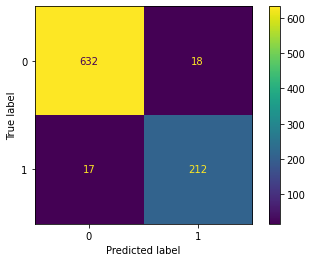

In [ ]:
plot_confusion_matrix(xgb_model_fin,
                      X_test,
                      y_test)

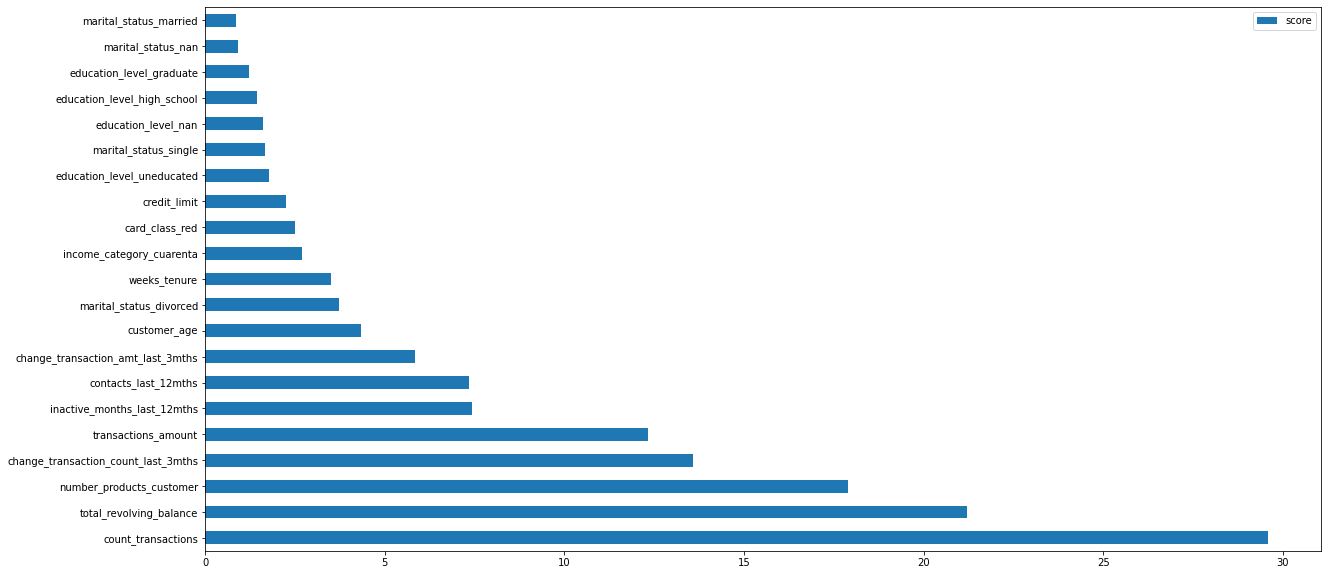

In [ ]:
feature_important = xgb_model_fin.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
feature_important

{'total_revolving_balance': 21.19903277141177,
 'change_transaction_count_last_3mths': 13.569537314102563,
 'number_products_customer': 17.896331264125003,
 'count_transactions': 29.591767518055562,
 'transactions_amount': 12.327551710082194,
 'change_transaction_amt_last_3mths': 5.830571327159089,
 'inactive_months_last_12mths': 7.421404549333332,
 'customer_age': 4.327968763409092,
 'contacts_last_12mths': 7.336900857399999,
 'weeks_tenure': 3.501334170117647,
 'income_category_cuarenta': 2.6950084245,
 'marital_status_divorced': 3.7213494799999998,
 'credit_limit': 2.2474284385555556,
 'marital_status_single': 1.6578154857499998,
 'education_level_high_school': 1.4303554250000001,
 'education_level_uneducated': 1.7715030866666668,
 'card_class_red': 2.51044035,
 'education_level_nan': 1.60679662,
 'marital_status_nan': 0.9025735855000001,
 'education_level_graduate': 1.21698737,
 'marital_status_married': 0.862603009}

In [ ]:
print(df[df['churn'] == 1]['count_transactions'].mean())
print(df[df['churn'] == 0]['count_transactions'].mean())

44.88461538461539
68.24692118226601


/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


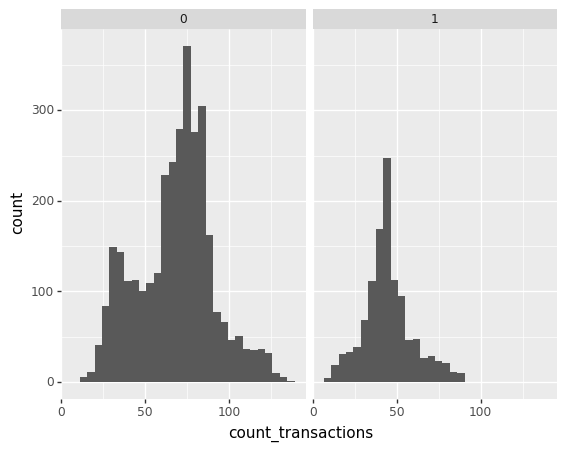

<ggplot: (8749204284589)>

In [ ]:
ggplot(df) + geom_histogram(aes('count_transactions')) + facet_wrap('churn')

Submission

In [ ]:
df_test = pd.read_csv('/content/test(1).csv')

In [ ]:
df_test.head()

,customer_id,customer_age,education_level,marital_status,income_category,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,card_class,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,change_transaction_count_last_3mths
0,4527,46.0,high school,married,70k€-110k€,5,142,3,9852.0,red,2,2277,71,3813,0.831,0.614
1,4166,47.0,college,single,50k€-70k€,4,131,2,1438.3,red,1,0,26,1468,0.810,0.625
2,4409,39.0,college,divorced,NaN,4,156,2,3264.0,red,3,2042,75,4624,0.752,0.705
3,6376,39.0,college,married,NaN,5,116,3,4693.0,red,1,634,79,4460,0.909,0.837
4,6367,42.0,uneducated,married,<30k€,2,115,0,2275.0,red,2,1265,77,5626,0.755,1.081


In [ ]:
df_test['customer_age'] = df_test['customer_age'].fillna(0)
df_test = pd.get_dummies(df_test, columns = ['education_level', 'marital_status', 'income_category', 'card_class'], dummy_na = True)
df_test.rename(columns={'income_category_<30k€': 'income_category_treinta', 
                   'income_category_70k€-110k€': 'income_category_setenta',
                   'income_category_30k€-50k€': 'income_category_cuarenta', 
                   'income_category_+110k€': 'income_category_cientodiez',
                   'income_category_50k€-70k€': 'income_category_sesenta'}, inplace=True)

In [ ]:
customer_id = df_test['customer_id']
df_test.drop('customer_id', axis = 1, inplace = True)

In [ ]:
df_test.head()

,customer_age,number_products_customer,weeks_tenure,contacts_last_12mths,credit_limit,inactive_months_last_12mths,total_revolving_balance,count_transactions,transactions_amount,change_transaction_amt_last_3mths,...,income_category_cuarenta,income_category_sesenta,income_category_setenta,income_category_treinta,income_category_nan,card_class_premium,card_class_red,card_class_red plus,card_class_red unlimited,card_class_nan
0,46.0,5,142,3,9852.0,2,2277,71,3813,0.831,...,0,0,1,0,0,0,1,0,0,0
1,47.0,4,131,2,1438.3,1,0,26,1468,0.810,...,0,1,0,0,0,0,1,0,0,0
2,39.0,4,156,2,3264.0,3,2042,75,4624,0.752,...,0,0,0,0,1,0,1,0,0,0
3,39.0,5,116,3,4693.0,1,634,79,4460,0.909,...,0,0,0,0,1,0,1,0,0,0
4,42.0,2,115,0,2275.0,2,1265,77,5626,0.755,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
pred = opt.predict(df_test)

In [ ]:
sum(pred) / len(pred)

0.257036643653744

In [ ]:
res = pd.DataFrame({'customer_id': customer_id,
                    'churn': pred})

In [ ]:
res

,customer_id,churn
0,4527,0
1,4166,0
2,4409,0
3,6376,0
4,6367,0
...,...,...
1878,5704,1
1879,6371,0
1880,3073,0
1881,1912,0


In [ ]:
res.to_csv(r'/content/submission_8.csv', index = False)